ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **02Apr21**

# 06a. Poisson 2D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\flux}{\boldsymbol{q}}
  \newcommand{\normal}{\boldsymbol{n}}
  \newcommand{\xpoint}{\boldsymbol{x}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\div}{div}
  \DeclareMathOperator{\grad}{grad}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Variational Form](#dbcweak)
 + [Poisson-Dirichlet Energy](#energy)
<br><br>
1. [Problem Solution](#solution)
 + [MOOSE Application Development](#dbcapp)
 + [Code a Diffusion Term Kernel](#dbcdiff)
 + [Code a Source Term Kernel](#dbcsource)
 + [Compile and Link Application](#compile1)
 + [Input File](#dbcinput)
 + [Run Application](#dbcrun)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Compute Error](#linearerror)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
 + [Compute Error](#quaderror)
<br><br>    
1. [Diffusion Flux Postprocessing](#diffusionfluxpostpro)
 + [Auxiliary Variable](#auxvar)
 + [Use MOOSE Diffusion Flux Auxiliary Kernel](#auxdiffflux)
    - [Compute Error](#difffluxerror1)
 + [Code a Diffusion Flux Auxiliary Kernel](#auxdiffflux2)
 + [Compile and Link Application](#compile2)
    - [Compute Error](#difffluxerror2)
<br><br>   
1. [Energy Postprocessing](#energypostpro)
 + [Code the Energy Postprocessor](#postpro)
 + [Compile and Link Application](#compilelink2)
 + [Input File](#energyinput)
 + [Run Application](#runenergy)
 + [Energy Results](#energyresults)
    - [Compute Error](#energyerror)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

 + Extend the Poisson 1D problem covered in [Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb) to 2D such that their solutions match. Notes for the 1D problem must be thoroughly reviewed.
 + Introduce the Galerkin variational (weak) form of the Poisson 2D problem below.
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span>
 + You are supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [2]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_solution_error(df, title='Dimensionless FEM Solution and Error', fem_type='No FEM type'):
    
    from engy_5310.toolkit import engy5310_p1_exact_solution

    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('dark_background')
    
    (u_hat, _, _) = engy5310_p1_exact_solution(x_left, x_right, u_left, u_right, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    a_hat = u_left/source_s*diff_coeff/L**2
    b_hat = u_right/source_s*diff_coeff/L**2

    uh_hat = df['u']/source_s*diff_coeff/L**2

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, uh_hat,'r-*',label=fem_type)
    
    plt.plot(x_hat, u_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, uh_hat-u_hat(x_hat, a_hat, b_hat), 'x', color='magenta', label=r'$\hat{u}_h-\hat{u}$')
    
    plt.title(label=title, fontsize=20)
    plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

In [3]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_flux_error(df, title='Dimensionless FEM Solution and Error', fem_type='No FEM type'):
    
    from engy_5310.toolkit import engy5310_p1_exact_solution
        
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('dark_background')
    
    (_, flux_hat, _) = engy5310_p1_exact_solution(x_left, x_right, u_left, u_right, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    
    a_hat = u_left/source_s*diff_coeff/L**2
    b_hat = u_right/source_s*diff_coeff/L**2

    flux_h_hat = df['diffFluxU_x']/source_s/L

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, flux_h_hat, 'r-*', label=fem_type)
    
    plt.plot(x_hat, flux_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, flux_h_hat-flux_hat(x_hat, a_hat, b_hat),'x',color='magenta',label=r'$\hat{q}_h-\hat{q}$')
    
    plt.title(label=title, fontsize=20)
    plt.ylabel(r'$\hat{q}_h, \hat{q}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the two-dimensional Poisson problem with Dirichlet boundary condition.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Poisson model problem. Find $u:\Omega\subset\Reals^2\rightarrow\Reals$ such that:

\begin{align*}
 -\div_\xpoint(-D\, \grad_\xpoint u) + S &= 0 \quad &\forall \quad \xpoint\in \Omega, \\
 u(\xpoint) &= u_\text{b}(\xpoint)            \quad &\forall \quad \xpoint\in \partial\Omega
\end{align*}
   
This problem has an analytical solution for certain domains $\Omega$ however this solution is not required here. The *flux*, $\flux:\Omega\rightarrow\Reals^2$, associated to the quantity $u$, is denoted $\flux := -D\,\grad u$, and it is often of interest as a derived quantity.

The value of the dependent variable is given on the boundary of the domain $\partial\Omega$. This is the extension of the *essential* boundary condition or  *Dirichlet boundary condition* to 2D.

### [Variational Form of Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin variational formulation is as follows. Find $u \in H^1\!\bigl(\Omega\bigr)$ so that 

\begin{align*}
 \int\limits_\Omega -D\, \grad_\xpoint u \cdot \grad_\xpoint v\,d\xpoint + \int\limits_\Omega S\,v(\xpoint)\,d\xpoint &= 0 \quad \forall \quad v \in H^1_0\!\bigl(\Omega\bigr), 
\end{align*}

where $H^1\!\bigl(\Omega\bigr) := \bigl\{ u:\Omega\subset\Reals\rightarrow \Reals \mid \int_\Omega \grad_\xpoint u\cdot\grad_\xpoint u\,d\xpoint < \infty \bigr\}$ and 
$H^1_0\!\bigl(\Omega\bigr) := \bigl\{ v \mid v \in H^1(\Omega), v|_{\partial\Omega} = 0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $v$ is called a test function. Because $v$ and $u$ are sought in very similar sets of functions, this variational form is called Galerkin's variational form.

The two integrals in the variational formulation are the key terms to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integrals, that is, the kernels. Therefore the kernels needed are:

 1. $-D\, \grad_\xpoint u \cdot \grad_\xpoint v$ ,
 1. $S\,v(\xpoint)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

### [Poisson-Dirichlet Energy](#toc)<a id="energy"></a>

It is of theoretical and practical importance to compute the associated energy that the variational form minimizes, that is the **Poisson-Dirichlet total energy**:

\begin{align*}
 \Phi[u] := \int\limits_\Omega \,\frac{1}{2}\flux(\xpoint)\cdot\flux(\xpoint) - D\,S\,u(\xpoint) \,d\xpoint.
\end{align*}

Since this is done after the solution is computed, it is characterized as a *postprocessing* operation. In `MOOSE` this is implemented in a *Postprocessors* class. First however, any derived quantity used in the integrand needs to be passed to the preprocessor for integration. Here we need to compute the local *flux*, $q$. In `MOOSE` this is done by creating an *auxiliary* variable and a corresponding *auxiliary kernel*. Therefore there are two additional components to [setup](#energypostpro):

1. Create the auxiliary variable $\flux=-D\,\grad u$,
1. Create the posprocessor for computing $\Phi$.

## [Problem Solution](#toc)<a id="solution"></a>

There is very little to do in order to extend the work done in 1D ([Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb)) if the programming was done with an eye towards 2D and 3D. The major work to be done is in the `MOOSE` input file.

### [MOOSE Application Development](#toc)<a id="dbcapp"></a>

We will use the same application development as in [Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb), namely `engy5310p1`.

### [Code a Diffusion Term Kernel](#toc)<a id="dbcdiff"></a>

No changes are necessary here since the  *residual* and *Jacobian* methods stand unmodified since the multiplication operator extends to 2D and performs an inner product of two vectors.
 + For the residual, a return value such as this is needed:
  ```c++
  Real
  DiffusionTerm::computeQpResidual()
  {
   return - _diffCoeff * _grad_u[_qp] * _grad_test[_i][_qp];
  }
  ```
 + For the Jacobian matrix diagonal, a return value such as this is needed:
  ```c++
  Real
  DiffusionTerm::computeQpJacobian()
  {
   return - _diffCoeff * _grad_phi[_j][_qp] * _grad_test[_i][_qp];
  }
  ```

### [Code a Source Term Kernel](#toc)<a id="dbcsource"></a>

Likewise no changes are needed for the source term; the *residual* and *Jacobian* methods remain to be:
 
 + For the residual, a return value such as this is needed:
  ```c++
  Real
  SourceTerm::computeQpResidual()
  {
   return _sourceS * _test[_i][_qp];
  }
  ```
 + For the Jacobian, a return value such as this is needed:
 ```c++
 Real
 SourceTerm::computeQpJacobian()
 {
  return 0.0;
 }
 ```


### [Compile and Link Application](#toc)<a id="compile1"></a>

Recompilation is not necessary but recall: 
1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="dbcinput"></a>

A full`input.hit`file is given in sections below when solving the problem. Here comments are made on the sections that need changes (refer to Notebook 06 for a review.). Some additional info on `MOOSE` **Hierarchical Input Text** (HIT) syntax can be found [here](https://mooseframework.inl.gov/application_usage/input_syntax.html).

```
# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00    # y coordinate min added
ymax = 6.25000e+00     # y coordinate max added
diff_coeff = 1.00000e-01
source_s = 1.00000e-03

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2                # 2D
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin} # new
    ymax = ${replace ymax} # new
    nx = 10
    ny = 2    # number of finite elements in y
  []
[]

[BCs]
  [south]                # y boundary condition at the bottom
    type = NeumannBC
    variable = u
    boundary = bottom
    value = 0.00000e+00
  []
  [north]                # y boundary condition at the top
    type = NeumannBC
    variable = u
    boundary = top
    value = 0.00000e+00
  []
[]

[Outputs]
  vtk = true         # enable VTK output for visualization in the Jupyter notebook
[]
```

An important observation on the boundary conditions on the *South* and *North* boundaries is that for the time being we will use a *no flux* boundary condition which allows us to solve the problem so that the exact solution is identical to the solution of the 1D problem. We will use this special boundary condition choice to verify the solution implementation and compute errors.

<div class="alert alert-block alert-info">
The development so far will allow you to solve the Poisson 2D problem as stated without computing the total energy. You should run the application at this point for testing and experimenting with the parameters and your implementation.
</div>

### [Run Application](#toc)<a id="dbcrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + See domain below
> + u_left = 3 g/cc
> + u_right = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements in the *x* direction: 3
> + num. of finite element in the *y* direction: any number

In [4]:
'''Domain'''

x_left = 0.0
x_right = 25.0
x_length = x_right - x_left

y_length = x_length/2
y_bottom = -y_length/2
y_top = -y_bottom

/home/dealmeida/.local/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


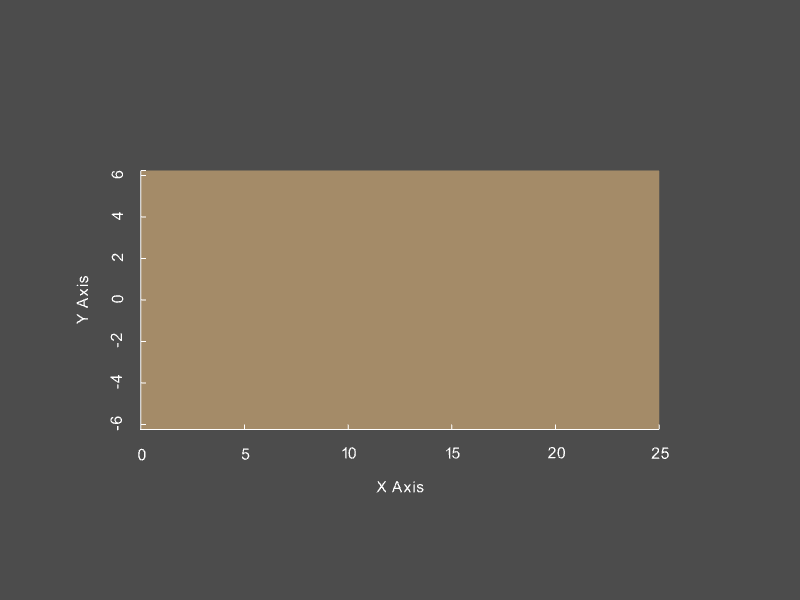

In [5]:
import pyvista as pv
import numpy as np
p1 = np.array([x_left, y_bottom, 0])
p2 = np.array([x_right, y_bottom, 0])
p3 = np.array([x_right, y_top, 0])
p4 = np.array([x_left, y_top, 0])
center = (p1+p2+p3+p4)/4
plane = pv.Plane(center=center, i_size=x_length, j_size=y_length)

plt = pv.Plotter()
plt.add_mesh(plane, color='tan')
plt.show_bounds()
cpos = plt.show(cpos='xy', window_size=[800,600])

In [6]:
'''Parameters and data'''

diff_coeff = 0.1
source_s = 1e-3

u_left = 3.0
u_right = 0.0

u_bottom = None # (equivalent of qn_bottom = 0)
u_top = None    # (equivalent of qn_top = 0 )

In [7]:
'''FEM Solution'''

n_felem_x = 3
n_felem_y = 1

order = 'first'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_x = 20
n_plot_pts_y = n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y)

In [8]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 08Oct21 18:02:32

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_left = 3.00000e+00
u_right = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 3
    ny = 1
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
    initial_condition = ${fparse (u_left+u_right)/2}
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
    coupledVariable = u
  []
[]

[BCs]
  [east]
    type = D

In [9]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         aebb5a5c0e1f6d8cf523a720e19f70a6d17c0236
PETSc Version:           3.15.0
SLEPc Version:           3.15.0
Current Time:            Fri Oct  8 18:02:43 2021
Executable Timestamp:    Fri Sep 24 22:36:35 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   8
  Elems:                   3
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                8
  Num Local DOFs:          8
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             Preconditioned JFNK
  PETSc Preconditioner:    hypre boomeramg 

 0 Nonlinear |R| = 2.479429e-01
      0 Linear |R| = 2.479429e-01
      1 Linear |R| = 4

In [ ]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='u', stitle='Concentration [g/cc]', cmap='plasma', window_size=[800,600], notebook=True)

The solution evaluated on $y=0$ must match the 1D solution in Notebook 06. Recall that the vector postprocessor `[x]` extracts the needed data into the `cvs` output file.

In [ ]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('out-x_x-line_0002.csv')
    
plot_solution(df, title='Dirichlet BC FEM Solution $u_h(x,y=0)$', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')

**Comments:**

1. The *concentration* drops from the entry value to the exit as prescribed by the boundary conditions.
1. Because of the source term the profile of the exact solution is quadratic.
1. Since the linear Lagrange basis functions are used with 3 finite elements, 3 linear sections approximate the solution.
1. The normal diffusion flux is negative on the left boundary, $(\flux\cdot\normal)|_{\xpoint = (a,y)} < 0$, 
hence there is *feeding* on the left. On the right boundary $(\flux\cdot\normal)|_{\xpoint = (a,y)} > 0$ therefore there is *draining* at the right side.

### [FEM Error](#toc)<a id="linearerror"></a>

In [ ]:
'''Error Compared to Exact Dimensionless Solution'''

plot_solution_error(df, title='Dimensionless FEM Solution and Error on $y=0$', fem_type='FEM Linear Lagrange')

**Comments:**

1. Error as compared to the exact dimensionless solution is zero at the boundary of the linear sections but not in between.
1. Even with linear Lagrange basis functions the error is relatively small and a proof that the use of basis functions of compact support is attractive.

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements in the *x* direction: 1
> + num. of finite element in the *y* direction: any number

The input file needs changes to select the higher order approximation:

```
[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2                # 2D
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin} # new
    ymax = ${replace ymax} # new
    nx = 10
    ny = 2    # number of finite elements in y
    elem_type = QUAD9  # name of the quadrilateral with 9 local basis functions
  []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = second                     # MOOSE second order Lagrange basis functions
  family = lagrange
 []
[]
```

In [ ]:
'''FEM Solution'''

n_felem_x = 1
n_felem_y = 1

order = 'second'

n_plot_pts_x = 2*n_felem_x + 1
n_plot_pts_x = 20
n_plot_pts_y = 2*n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y)

In [ ]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

In [ ]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

/home/dealmeida/.local/lib/python3.9/site-packages/pyvista/plotting/plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)
/home/dealmeida/.local/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


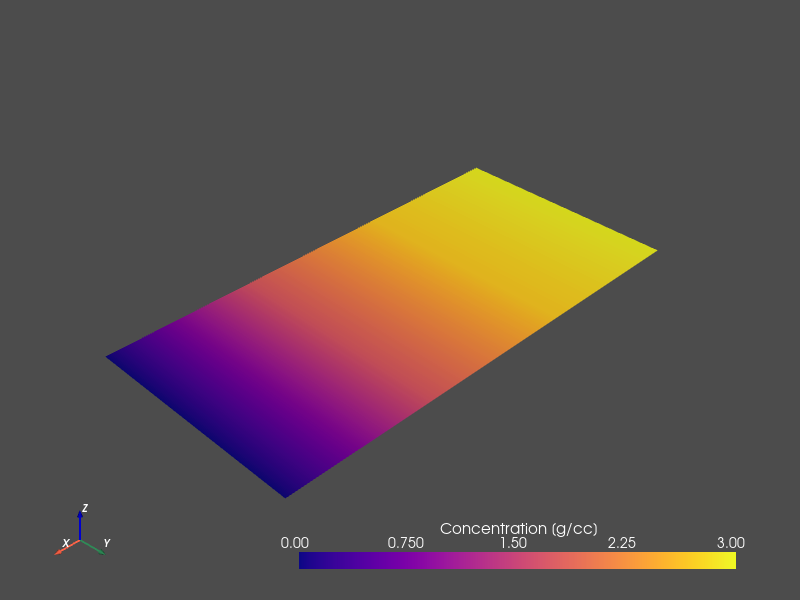

In [10]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='u', stitle='Concentration [g/cc]', cmap='plasma', window_size=[800,600], notebook=True)

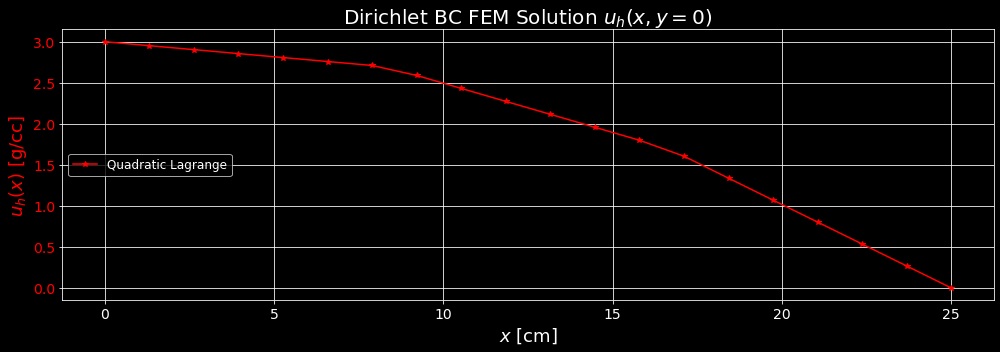

In [11]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('out-x_x-line_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution $u_h(x,y=0)$', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

### [FEM Error](#toc)<a id="quaderror"></a>


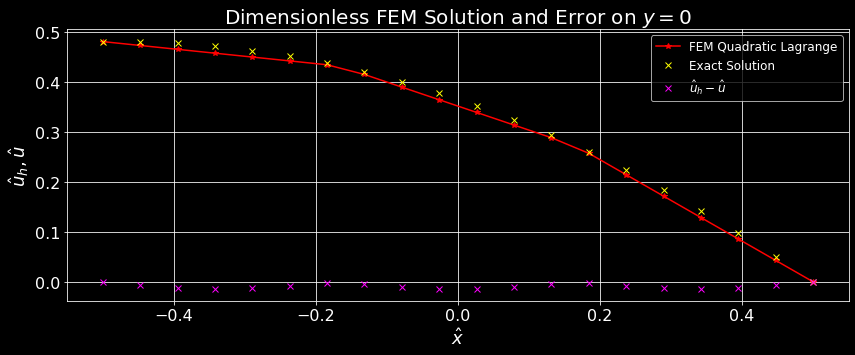

In [12]:
'''Error Compared to Exact Dimensionless Solution'''

plot_solution_error(df, title='Dimensionless FEM Solution and Error on $y=0$', fem_type='FEM Quadratic Lagrange')

**Comments:**

1. Usage of one quadratic Lagrange finite element reproduces the exact solution; as it had to.
1. Also the flux is exactly approximated as shown below.

## [Diffusion Flux Postprocessing](#toc)<a id="diffusionfluxpostpro"></a>

The diffusion flux is needed in the [Dirichlet energy](#energy) integral. This section describes the post-processing operation of calculating the flux $q$ from $u$. There are two ways to postprocess the diffusion flux as described below. In both of them, auxiliary variables need to be created.

### [Auxiliary Variable](#toc)<a id="auxvar"></a>

A derived variable for the diffusion flux vector calculated from the unknown $u$ needs to be specified in the `MOOSE` input file. The shape of the basis functions used for the diffusion flux should be consistent with the choice used for the $u$ variable. For example:

```
[AuxVariables]
  [diffFluxU]               # a vector valued flux
    order = FIRST
    family = MONOMIAL_VEC   # vector valued
  []
  [diffFluxU_x]             # x component
    order = FIRST
    family = MONOMIAL
  []
  [diffFluxU_y]             # y component
    order = FIRST
    family = MONOMIAL
  []
[]
```

### [Use `MOOSE` Diffusion Flux Auxiliary Kernel](#toc)<a id="auxdiffflux"></a>

One way to compute the gradient of $u$ is to use the `MOOSE` framework `DiffusionFluxAux` kernel.
It is available for computing the flux $\flux$ but each component must be created separately using the `MOOSE` input file as follows:

```
[AuxKernels]
  [diffusion-flux-x]
    execute_on = timestep_end
    type = DiffusionFluxAux
    diffusivity = ${replace diff_coeff}
    variable = diffFluxU_x
    diffusion_variable = u
    component = x
  []
  [diffusion-flux-y]
    execute_on = timestep_end
    type = DiffusionFluxAux
    diffusivity = ${replace diff_coeff}
    variable = diffFluxU_y
    diffusion_variable = u
    component = y
  []
[]
```

Also, you need to output the values of flux for plotting; just add the newly created auxiliary field to the list of variables (`# output data`) on the `VectorPostprocessors` block output file, that is:

```
[VectorPostprocessors]
  [x]
    type = LineValueSampler
    execute_on = 'timestep_end final'
    variable = 'u diffFluxU_x diffFluxU_y'      # output data
    start_point = '${replace xmin} 0 0'
    end_point = '${replace xmax} 0 0'
    num_points = 20
    sort_by = id
  []
[]
```

In [ ]:
'''FEM Solution'''

n_felem_x = 1
n_felem_y = 1

order = 'second'

n_plot_pts_x = 2*n_felem_x + 1
n_plot_pts_x = 20
n_plot_pts_y = 2*n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, 
                                compute_diffusion_flux=True, use_moose_diffusion_flux=True)

In [ ]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

In [ ]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

In [ ]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_x', stitle='Diffusion Flux X [g/(cm^2 s)]', cmap='plasma', notebook=True) 

In [ ]:
'''Show 2D y flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_y', stitle='Diffusion Flux Y [g/(cm^2 s)]', cmap='plasma', notebook=True)

In [ ]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('out-x_x-line_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution $u_h(x,y=0)$, $q_{h,x}(x,y=0)$', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

#### [Compute Error](#toc)<a id="difffluxerror1"></a>


In [ ]:
'''Flux Error Compared to Exact Dimensionless Solution'''

plot_flux_error(df, title='Dimensionless FEM Solution and Error on $y=0$', fem_type='FEM Quadratic Lagrange')

### [Code a Diffusion Flux Auxiliary Kernel](#toc)<a id="auxdiffflux2"></a>

Only the flux vector auxiliary kernel will be described here (see Notebook 06 for other options).

1. `cd include`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFlux.h` class interface as folows:
 + Use the `FluxVector.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxVector.h) as follows:
 + `cp *path-to*/moose-app-templates/FluxVector.h .`
 + `mv VectorFlux.h DiffusionFlux.h`
 + Edit the file `DiffusionFlux.h` with a text editor by replacing all instances of `FluxVector` with `DiffusionFlux`.
 + Declare member variables in the header files for example:
 ```c++
  /// The gradient of a coupled variable
  const VariableGradient & _gradU;
  /// Add here other parameters needed
  Real _diffCoeff;
 ```
1. `cd ../..`
1. `cd src`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFlux.C` class implementation as follows:
 + Use the `FluxVector.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxVector.C) as follows.
 + `cp *path-to*/moose-app-templates/FluxVector.C .`
 + `mv FluxVector.C DiffusionFlux.C`
 + Edit the file `DiffusionFlux.C` with a text editor by replacing all instances of `FluxVector` with `DiffusionFlux`.
 + You will need to program the *computeValue()* method. <span style="color:red">This portion of the implementation is convered in class.</span> Here is an example of what the method would look like:
```c++
DiffusionFlux::DiffusionFlux(const InputParameters & parameters)
  : VectorAuxKernel(parameters),
    // Initialize variable gradient
    _gradU(coupledGradient("field")),
    // Initialize parameters
    _diffCoeff(getParam<Real>("diffCoeff"))
{
}
RealVectorValue
DiffusionFlux::computeValue()
{
  return - _diffCoeff * _gradU[_qp];
}
```

Depending on your implementation, the `MOOSE` input block may look like this:

```
[AuxKernels]
  [diffusion-flux]
    execute_on = timestep_end
    type = DiffusionFlux      # user coded kernel
    field = u
    diffCoeff = ${replace diff_coeff}
    variable = diffFluxU     # produced quantity
  []
  [diffusion-flux-x]
    execute_on = timestep_end
    type = VectorVariableComponentAux    #  MOOSE provided
    variable = diffFluxU_x    # produced quantity
    component = x
    vector_variable = diffFluxU   
  []
  [diffusion-flux-y]
    execute_on = timestep_end
    type = VectorVariableComponentAux    #  MOOSE provided
    variable = diffFluxU_y    # produced quantity
    component = y
    vector_variable = diffFluxU   
  []
[]
```

### [Compile and Link Application](#toc)<a id="compile2"></a>

1. Make sure you are in the problem project directory:
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

In [ ]:
'''FEM Solution'''

n_felem_x = 1
n_felem_y = 1

order = 'second'

n_plot_pts_x = 2*n_felem_x + 1
n_plot_pts_x = 20
n_plot_pts_y = 2*n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, 
                                compute_diffusion_flux=True)

In [ ]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

In [ ]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

In [ ]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_x', stitle='Diffusion Flux X [g/(cm^2 s)]', cmap='plasma', notebook=True) 

In [ ]:
'''Show 2D y flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_y', stitle='Diffusion Flux Y [g/(cm^2 s)]', cmap='plasma', notebook=True)

In [ ]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('out-x_x-line_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution $u_h(x,y=0)$, $q_{h,x}(x,y=0)$', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

#### [Compute Error](#toc)<a id="difffluxerror2"></a>

In [ ]:
'''Error Compared to Exact Dimensionless Solution'''

plot_flux_error(df, title='Dimensionless FEM Solution and Error on $y=0$', fem_type='FEM Quadratic Lagrange')

## [Energy Postprocessing](#toc)<a id="energypostpro"></a>

To compute the [Poisson-Dirichlet energy](#energy) a *Postprocessor* needs to be built. The user-developed class should use the previously computed diffusion flux component. With an eye towards the future use of this application in 2D and 3D, call this new class, `BulkEnergy`.

### [Code the Energy Postprocessor](#toc)<a id="postpro"></a>

1. `cd include`
1. `mkdir postprocessors`
1. `cd postprocessors`
1. Create a `BulkEnergy.h` class interface as folows:
 + Use the `ScalarVariableIntegralPostprocessor.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/ScalarVariableIntegralPostprocessor.h) as follows:
 + `cp *path-to*/moose-app-templates/ScalarVariableIntegralPostprocessor.h .`
 + `mv ScalarVariableIntegralPostprocessor.h BulkEnergy.h`
 + Edit the file `BulkEnergy.h` with a text editor by replacing all instances of `ScalarVariableIntegralPostprocessor` with `BulkEnergy`.
1. `cd ../..`
1. `cd src`
1. `mkdir postprocessors`
1. `cd postprocessors`
1. Create a `BulkEnergy.C` class implementation as follows:
 + Use the `ScalarVariableIntegralPostprocessor.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/ScalarVariableIntegralPostprocessor.C) as follows.
 + `cp *path-to*/moose-app-templates/ScalarVariableIntegralPostprocessor.C .`
 + `mv ScalarVariableIntegralPostprocessor.C BulkEnergy.C`
 + Edit the file `BulkEnergy.C` with a text editor by replacing all instances of `ScalarVariableIntegralPostprocessor` with `BulkEnergy`.
 + You will need to program the *computeValue()* method. See the example below for the input file *Postprocessor* block and the parameters needed. <span style="color:red">This portion of the implementation is convered in class.</span>

### [Compile and Link Application](#toc)<a id="compilelink2"></a>

1. Make sure you are in the problem project directory:
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="energyinput"></a>

A new *Postprocessors* block should be created; an example follows:

```
[Postprocessors]
  [bulk-energy]
    type = BulkEnergy                                    # user-defined
    execute_on = 'timestep_end final'
    variable = 'u'     # bulk energy unknown variable    # user-defined 
    diffCoeff = ${replace diff_coeff}                    # user-defined
    sourceS = ${replace source_s}                        # user-defined
  []
[]
```

### [Run Application](#toc)<a id="runenergy"></a>

Using an updated input file (see below) run the application as follows:
1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

### [Energy Results](#toc)<a id="energyresults"></a>

In [ ]:
'''FEM Solution'''

n_felem_x = 1
n_felem_y = 1

order = 'second'

n_plot_pts_x = 2*n_felem_x + 1
n_plot_pts_x = 20
n_plot_pts_y = 2*n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, 
                                compute_energy=True)

In [ ]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

In [ ]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

#### [Compute Error](#toc)<a id="energyerror"></a>

In [ ]:
import pandas as pd
df = pd.read_csv('out_energy.csv')

fem_energy = df['bulk-energy'][0]

L = x_right - x_left

fem_energy_hat = fem_energy/(y_top-y_bottom)/source_s**2/L**3
print('FEM energy   [] = %10.6e'%(fem_energy_hat))

from engy_5310.toolkit import engy5310_p1_exact_solution

(_, _, energy_hat) = engy5310_p1_exact_solution(x_left, x_right, u_left, u_right, diff_coeff, source_s)

print('Exact energy [] = %10.6e'%(energy_hat))

print('Energy rel. error [%%] = %10.3e'%((fem_energy_hat-energy_hat)/energy_hat*100))

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [ ]:
!tree engy5310p1